# Setting up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context="talk")

In [2]:
df=pd.read_csv('final_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54063292 entries, 0 to 54063291
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   unit_sales      float64
 3   onpromotion     bool   
 4   city            object 
 5   state           object 
 6   type            object 
 7   cluster         int64  
 8   family          object 
 9   class           int64  
 10  perishable      int64  
 11  avg_unit_sales  float64
dtypes: bool(1), float64(2), int64(4), object(5)
memory usage: 4.5+ GB


# Temporal analysis

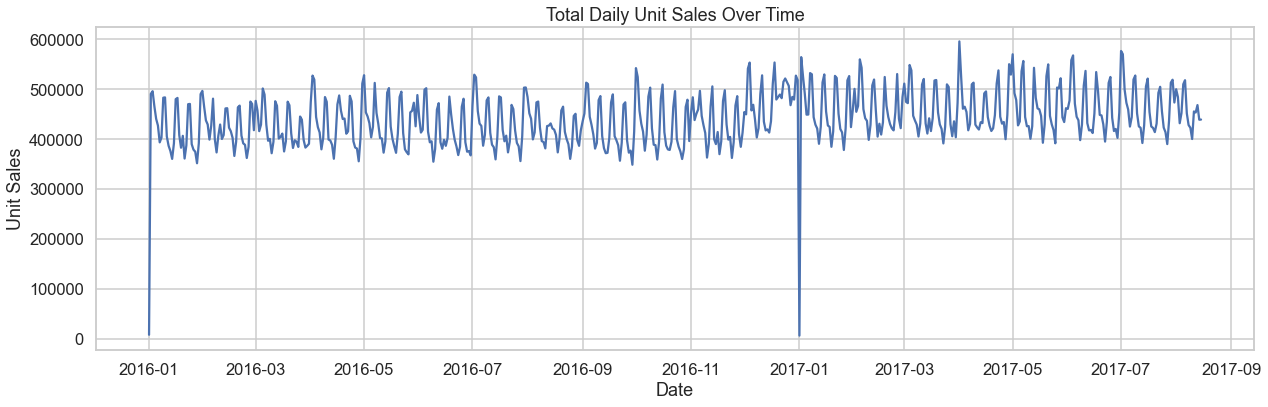

In [3]:
df['date'] = pd.to_datetime(df['date'])
daily_sales = df.groupby('date')['unit_sales'].sum().reset_index()

plt.figure(figsize=(18, 6))
sns.lineplot(data=daily_sales, x='date', y='unit_sales')
plt.title('Total Daily Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


Clear Weekly Seasonality: There's a recurring pattern of peaks and troughs within each week, indicating a strong weekly cycle in sales.
Relatively Stable Overall Level: For most of the period, the average daily sales appear to be within a consistent range, roughly between 400,000 and 500,000 units.
A Notable Outlier: There's a significant dip in sales around the beginning of January 2017, followed by a quick recovery. This suggests an unusual event or anomaly at that time.
Slight Increase in Volatility Later On: The fluctuations in daily sales seem to become slightly more pronounced in the latter part of 2017 compared to the earlier period.

In [4]:
full_dates = pd.date_range(start=df['date'].min(), end=df['date'].max())
actual_dates = pd.Series(df['date'].unique())
missing_dates = full_dates.difference(actual_dates)
missing_dates = pd.DataFrame(missing_dates, columns=['missing_date'])
print("Missing dates in the time series:")
print(missing_dates)


Missing dates in the time series:
  missing_date
0   2016-12-25


In [5]:
holidays=pd.read_csv('favorita-grocery-sales-forecasting/holidays_events.csv/holidays_events.csv')
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [6]:

christmas_2016 = holidays[holidays['date'] == '2016-12-25']
print(christmas_2016)


           date     type    locale locale_name description  transferred
294  2016-12-25  Holiday  National     Ecuador     Navidad        False


Christmas Day (2016-12-25) was a national holiday, not transferred, and likely stores were closed → explains why there's no data (missing row).

In [7]:
holidays = pd.read_csv('favorita-grocery-sales-forecasting/holidays_events.csv/holidays_events.csv', parse_dates=['date'])
holidays_jan = holidays[holidays['date'].dt.month == 1]
holidays_jan_2016 = holidays_jan[holidays_jan['date'].dt.year == 2016]
holidays_jan_2017 = holidays_jan[holidays_jan['date'].dt.year == 2017]

print("2016 Jan holidays:")
print(holidays_jan_2016[['date', 'type', 'description', 'transferred']])

print("\n2017 Jan holidays:")
print(holidays_jan_2017[['date', 'type', 'description', 'transferred']])


2016 Jan holidays:
          date     type         description  transferred
211 2016-01-01  Holiday  Primer dia del ano        False

2017 Jan holidays:
          date      type                  description  transferred
297 2017-01-01   Holiday           Primer dia del ano         True
298 2017-01-02  Transfer  Traslado Primer dia del ano        False


In [8]:
df[df['date'].dt.month == 1]['date'].dt.year.value_counts()


2017    2862270
2016    2565244
Name: date, dtype: int64

How many transactions happen in the first month

In [9]:
# List of dates of interest
holiday_dates = ['2016-01-01', '2017-01-01', '2017-01-02']

# Filter and group
sales_on_holidays = (
    df[df['date'].isin(pd.to_datetime(holiday_dates))]
    .groupby('date')['unit_sales']
    .sum()
    .reset_index()
)

print(sales_on_holidays)


        date  unit_sales
0 2016-01-01    7659.994
1 2017-01-01    5980.906
2 2017-01-02  564148.829


Sales dipped on the holiday (expected).

Bounce back on 2017-01-02 shows pent-up demand — people probably shopped the day after.

This is a clear holiday effect pattern, and could be a useful feature signal in modeling

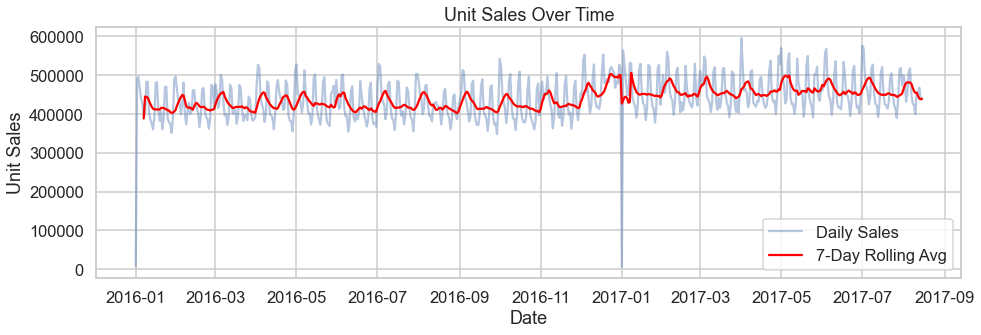

In [10]:
# Daily total sales
daily_sales = df.groupby('date')['unit_sales'].sum()

# Rolling average to smooth noise
rolling_sales = daily_sales.rolling(7).mean()

plt.figure(figsize=(14, 5))
plt.plot(daily_sales, label='Daily Sales', alpha=0.4)
plt.plot(rolling_sales, label='7-Day Rolling Avg', color='red')
plt.title("Unit Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Seasonality: There appears to be a clear weekly seasonality in the daily sales. We can observe peaks and troughs occurring roughly every 7 days. Sales tend to be higher at certain points in the week and lower at others.
Overall Trend: While there are fluctuations, the overall trend in daily sales seems relatively stable between early 2016 and late 2017. There isn't a strong upward or downward long-term trend visible.
Rolling Average Smoothing: The 7-day rolling average (red line) effectively smooths out the daily fluctuations, making the underlying short-term trends and overall stability clearer.
Potential Outlier: There is a sharp drop in daily sales around the beginning of January 2017, followed by a quick recovery. This could indicate a significant event or anomaly that temporarily impacted sales.
Slight Increase in Volatility: It seems that the volatility of daily sales might have slightly increased in the later half of 2017 compared to 2016, although the rolling average remains relatively stable.

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\2292531007.py:22: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


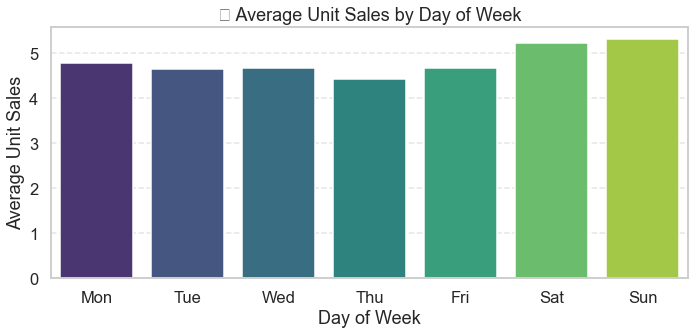

In [11]:
# Add a column for day of the week
df['day_of_week'] = df['date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Group and average unit sales
dow_sales = df.groupby('day_of_week')['unit_sales'].mean().reset_index()

# Optional: Map day numbers to names
dow_sales['day_name'] = dow_sales['day_of_week'].map({
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'
})

# Sort for nice plotting order
dow_sales = dow_sales.sort_values('day_of_week')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=dow_sales, x='day_name', y='unit_sales', palette='viridis')
plt.title("🛒 Average Unit Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Unit Sales")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Lower Sales on Weekdays: The average unit sales appear to be lower on Monday, Tuesday, Wednesday, and Thursday, with values below 5.
Increasing Sales Towards the Weekend: The average unit sales tend to increase towards the end of the week, with Friday showing a noticeable rise compared to the earlier weekdays.
Highest Sales on Weekend: Saturday and Sunday exhibit the highest average unit sales, with values exceeding 5. Sunday appears to have the slightly highest average unit sales among all days.

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\3478431841.py:18: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


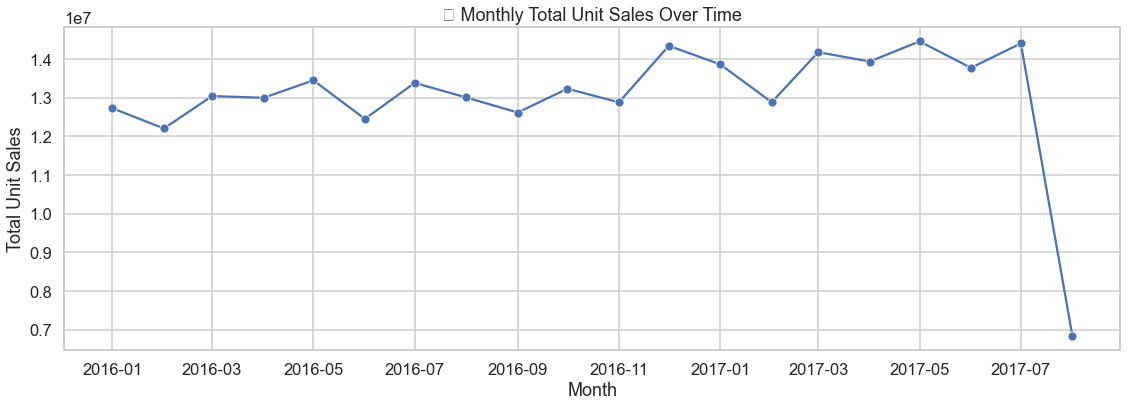

In [12]:
# Extract month as integer (1–12) and year for grouping
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Group by year and month
monthly_sales = df.groupby(['year', 'month'])['unit_sales'].sum().reset_index()

# Combine year and month for easy plotting
monthly_sales['year_month'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

# Plot
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_sales, x='year_month', y='unit_sales', marker='o')
plt.title("📅 Monthly Total Unit Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Total Unit Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


Relatively Stable Sales (Early 2016 - Mid 2017): The total monthly unit sales fluctuate within a relatively consistent range, approximately between 1.2 million and 1.45 million units, from January 2016 up to around June/July 2017. There isn't a clear increasing or decreasing trend during this period.
Peaks in Sales: There appear to be peaks in total monthly unit sales around November 2016 and March 2017, reaching the highest points in the observed timeframe before the significant drop.

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


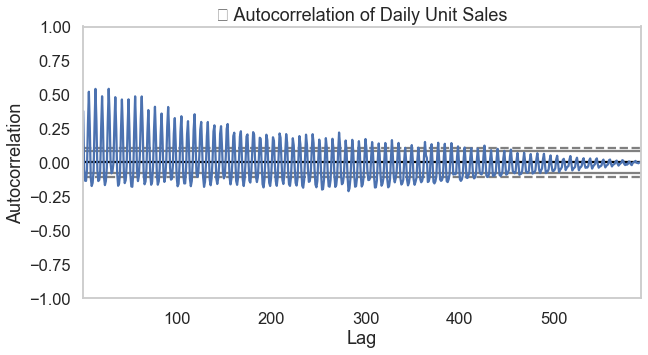

In [13]:
from pandas.plotting import autocorrelation_plot

# Use daily sales
daily_sales = df.groupby('date')['unit_sales'].sum()

plt.figure(figsize=(10, 5))
autocorrelation_plot(daily_sales)
plt.title("🔁 Autocorrelation of Daily Unit Sales")
plt.show()


Observations:

Strong Weekly Seasonality: The most prominent feature is the clear and significant positive autocorrelation at lags that are multiples of 7 (approximately 7, 14, 21, etc.). This strongly confirms the weekly seasonality we observed in the original time series plot. The sales on a given day are highly correlated with the sales from the same day of the week in the previous week, two weeks ago, and so on.
Oscillating Pattern: The autocorrelation plot shows an oscillating pattern. After a positive peak at a lag of 7, there's a negative correlation at lags around 3-4 and then another positive peak at lag 14, and so on. This is typical for time series with strong seasonality.
Gradual Decay: The magnitude of the autocorrelation coefficients gradually decreases as the lag increases. This suggests that the influence of past sales on current sales diminishes over time. However, the seasonal peaks remain significant even at larger lags within the displayed range.
Significant Correlations Beyond Randomness: Many of the autocorrelation coefficients extend beyond the dashed lines, which typically represent the 95% confidence interval for white noise. This indicates that these correlations are statistically significant and not just due to random chance.
What this tells us:

Seasonality is a Key Driver: Any forecasting model for this data must account for the strong weekly seasonality. Ignoring this will likely lead to poor forecast accuracy.
Short-Term Dependencies: The significant autocorrelation at shorter lags (beyond the weekly cycle) suggests some short-term dependencies in the daily sales that might also be worth exploring in modeling.

In [14]:
# Example: 7-day lag
df_lag = df.groupby('date')['unit_sales'].sum().to_frame()
df_lag['unit_sales_lag7'] = df_lag['unit_sales'].shift(14)

# Correlation
df_lag.dropna().corr()


,unit_sales,unit_sales_lag7
unit_sales,1.000000,0.579257
unit_sales_lag7,0.579257,1.000000


C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1476440007.py:15: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


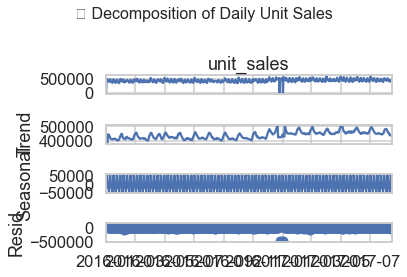

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample to daily
daily_sales = df.groupby('date')['unit_sales'].sum().asfreq('D')

# Fill missing days with 0s (or interpolate)
daily_sales = daily_sales.fillna(0)

# Decompose (assume additive; try multiplicative too)
decomp = seasonal_decompose(daily_sales, model='additive', period=7)

# Plot components
decomp.plot()
plt.suptitle("🧩 Decomposition of Daily Unit Sales", fontsize=16)
plt.tight_layout()
plt.show()


Original Time Series (Top Subplot): This shows the raw daily unit sales data over time, displaying the fluctuations, seasonality, and the outlier around early 2017 that we've seen in previous plots.

Trend Component (Second Subplot): This isolates the underlying trend in the sales data after removing the seasonal and residual components. The trend appears relatively stable with some gradual variations. It shows a slight dip corresponding to the outlier in the original data and doesn't exhibit a strong upward or downward long-term movement for most of the period.

Seasonal Component (Third Subplot): This clearly illustrates the recurring weekly seasonality in the daily unit sales. The pattern repeats consistently throughout the time series, showing a regular cycle of increases and decreases within each week. The amplitude of the seasonal fluctuations appears relatively stable over time.

Residual Component (Bottom Subplot): This represents the remaining variation in the daily unit sales after removing the trend and seasonal components. Ideally, this should look like random noise. We can observe some larger residuals, particularly corresponding to the outlier in the original data, indicating that this event was not explained by the trend or seasonality. There might be some other smaller, less obvious patterns in the residuals that could potentially be investigated further.

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_sales.dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.459269762331559
p-value: 0.009096861227454471


Since the p-value is low, we have strong evidence to reject the null hypothesis. Therefore, the daily sales data (after removing any potential NaN values) is likely stationary. This means that the statistical properties of the series, such as its mean and variance, do not change over time. Stationarity is an important assumption for many time series models.

In [17]:
seasonality_strength = 1 - (np.var(decomp.resid) / np.var(decomp.resid + decomp.seasonal))
print("Seasonality Strength:", seasonality_strength)


Seasonality Strength: 0.4963389226163517


Value of 0.496: A seasonality strength of approximately 0.5 suggests that the seasonal component accounts for a substantial portion (around 50%) of the variability in the daily unit sales after removing the trend. This quantitatively confirms the strong weekly seasonality we observed visually in the time series plots and the ACF.

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\163781947.py:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


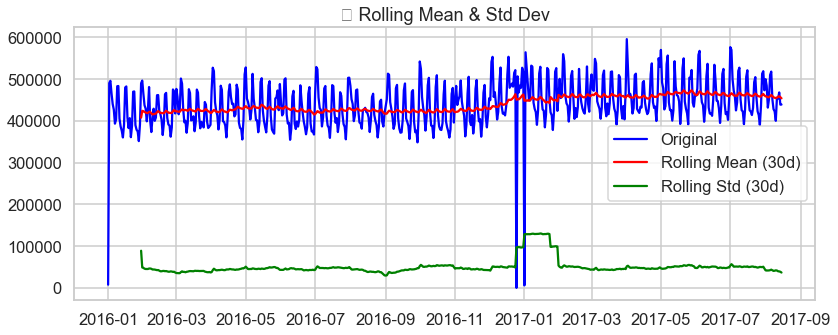

In [18]:
rolling_mean = daily_sales.rolling(window=30).mean()
rolling_std = daily_sales.rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(daily_sales, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean (30d)')
plt.plot(rolling_std, color='green', label='Rolling Std (30d)')
plt.title('📈 Rolling Mean & Std Dev')
plt.legend()
plt.tight_layout()
plt.show()


Non-Constant Variance (Heteroscedasticity): The rolling standard deviation is not constant over time, suggesting that the variance of the daily unit sales might be changing. This is a form of heteroscedasticity, which can be important to consider when building forecasting models.
Outlier Impact: The rolling statistics clearly show the impact of the outlier on both the average and the volatility of sales in its vicinity.
Potential Seasonality in Volatility: The fluctuations in the rolling standard deviation might also be related to the weekly seasonality, although it's not as directly evident as in the original data or the rolling mean.

# Spatial Analysis

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\739657675.py:14: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


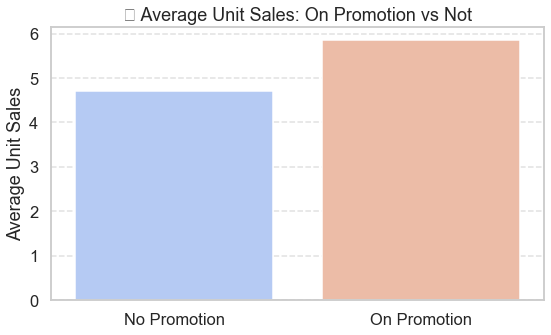

In [19]:
# Group by promotion flag
promo_impact = df.groupby('onpromotion')['unit_sales'].mean().reset_index()

# Rename for clarity
promo_impact['onpromotion'] = promo_impact['onpromotion'].map({True: 'On Promotion', False: 'No Promotion'})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=promo_impact, x='onpromotion', y='unit_sales', palette='coolwarm')
plt.title("🎯 Average Unit Sales: On Promotion vs Not")
plt.ylabel("Average Unit Sales")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


the chart clearly shows that the average unit sales are significantly higher when the product is on promotion compared to when it is not. The promotion leads to an increase of roughly 1.2 units in average sales.

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\54923971.py:3: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from current font.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\54923971.py:3: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


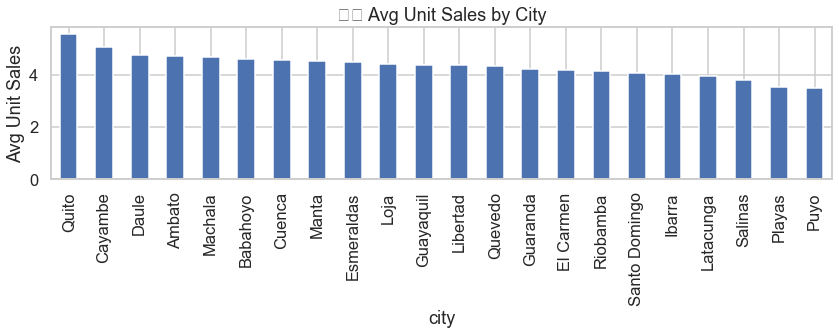

In [20]:
df.groupby('city')['unit_sales'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(12,5), title='🏙️ Avg Unit Sales by City')
plt.ylabel('Avg Unit Sales')
plt.tight_layout()
plt.show()


Quito has the highest average unit sales, followed by Cayambe and Daule. The average unit sales generally decrease as you move from left to right across the cities, with Puyo having the lowest average unit sales among the cities listed. There is a noticeable variation in average unit sales across the different cities.

<AxesSubplot:title={'center':'🔗 Avg Sales by Store Cluster'}, xlabel='cluster'>

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


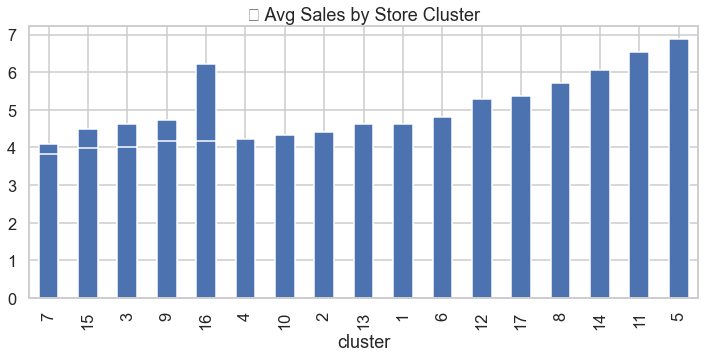

In [21]:
# Store type
df.groupby('type')['unit_sales'].mean().sort_values().plot(kind='bar', title='🏬 Avg Unit Sales by Store Type')

# Cluster
df.groupby('cluster')['unit_sales'].mean().sort_values().plot(kind='bar', figsize=(12,5), title='🔗 Avg Sales by Store Cluster')


C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\3014533274.py:7: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


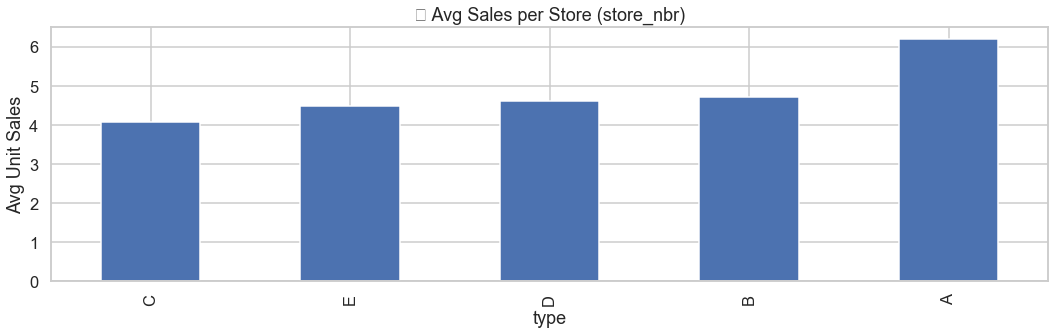

In [22]:
store_sales = df.groupby('type')['unit_sales'].mean()

plt.figure(figsize=(15,5))
store_sales.sort_values().plot(kind='bar')
plt.title("🏪 Avg Sales per Store (store_nbr)")
plt.ylabel("Avg Unit Sales")
plt.tight_layout()
plt.show()


Lowest Average Sales: Store type C has the lowest average unit sales among the types shown.
Increasing Trend: There appears to be a general increasing trend in average unit sales as we move from store type C to E, then D, then B.
Highest Average Sales: Store type A exhibits the highest average unit sales, significantly higher than the other store types.

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1027674180.py:3: UserWarning: Glyph 129382 (\N{BROCCOLI}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 129382 (\N{BROCCOLI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


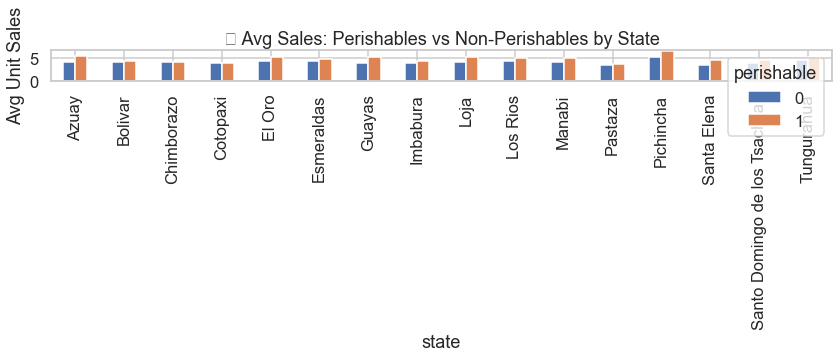

In [23]:
df.groupby(['state', 'perishable'])['unit_sales'].mean().unstack().plot(kind='bar', figsize=(12,5), title='🥦 Avg Sales: Perishables vs Non-Perishables by State')
plt.ylabel("Avg Unit Sales")
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\816509727.py:3: UserWarning: Glyph 128227 (\N{CHEERING MEGAPHONE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128227 (\N{CHEERING MEGAPHONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


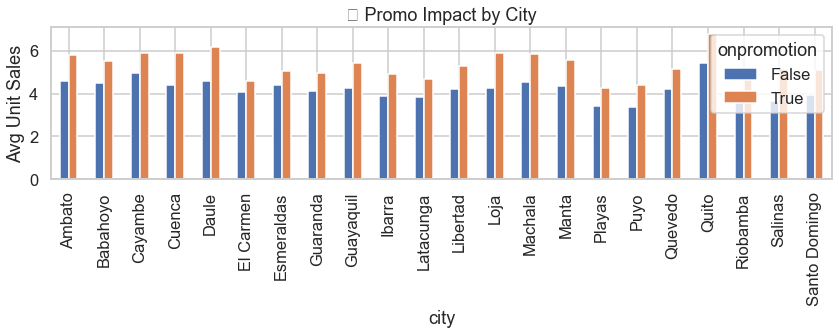

In [24]:
df.groupby(['city', 'onpromotion'])['unit_sales'].mean().unstack().plot(kind='bar', figsize=(12,5), title='📣 Promo Impact by City')
plt.ylabel('Avg Unit Sales')
plt.tight_layout()
plt.show()


Promotion Generally Increases Sales: For almost every city shown, the orange bar (on promotion) is higher than the blue bar (not on promotion), indicating that promotions generally lead to an increase in average unit sales across different cities.
Varying Promotion Impact: The magnitude of the increase in average unit sales due to promotion varies across cities. In some cities, the difference between the blue and orange bars is substantial (e.g., Babahoyo, Daule, Libertad), while in others, the impact is smaller (e.g., Ambato, Cuenca, Guayaquil).
Cities with High Baseline Sales: Some cities have relatively high average unit sales even without promotions (e.g., Babahoyo, Daule, Quito).
Cities with Low Baseline Sales: Other cities have lower average unit sales when not on promotion (e.g., Playas, Puyo, Salinas).
Consistent Positive Impact: Despite the varying degrees, the impact of promotion appears to be consistently positive across the majority of the represented cities.

# Spatio Temperal analysis

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\2773394752.py:13: UserWarning: Glyph 128368 (\N{MANTELPIECE CLOCK}) missing from current font.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\2773394752.py:13: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128368 (\N{MANTELPIECE CLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


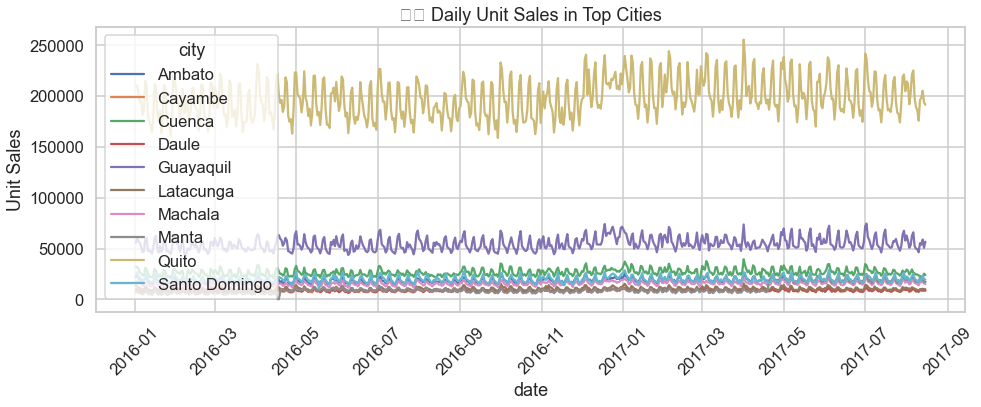

In [25]:
# Daily sales per city
city_daily = df.groupby(['date', 'city'])['unit_sales'].sum().reset_index()

# Plot for top N cities
top_cities = city_daily.groupby('city')['unit_sales'].sum().sort_values(ascending=False).head(10).index
top_city_daily = city_daily[city_daily['city'].isin(top_cities)]

plt.figure(figsize=(14,6))
sns.lineplot(data=top_city_daily, x='date', y='unit_sales', hue='city')
plt.title('🕰️ Daily Unit Sales in Top Cities')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Quito Dominates Sales: The yellow-brown line representing Quito shows significantly higher daily unit sales compared to all other listed cities throughout the entire period.
Guayaquil Shows Moderate Sales: The purple line for Guayaquil indicates the second-highest daily unit sales, consistently above the other remaining cities but far below Quito.
Lower Sales in Other Cities: The remaining cities (Ambato, Cayambe, Cuenca, Daule, Latacunga, Machala, Manta, Santo Domingo) exhibit considerably lower daily unit sales, with their lines clustered near the bottom of the plot.
Seasonality Appears in Some Cities: Some cities, particularly Quito and Guayaquil, seem to display a recurring seasonal pattern in their daily sales, with noticeable peaks and troughs throughout the year. This pattern might be less apparent in the cities with lower overall sales due to the scale.
Outlier in Quito: There's a noticeable dip and recovery in Quito's sales around early 2017, similar to the overall sales pattern observed earlier.
Varying Trends: While Quito and Guayaquil show relatively consistent patterns, the other cities have lower and seemingly more variable daily sales within their smaller ranges.

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1898146989.py:8: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


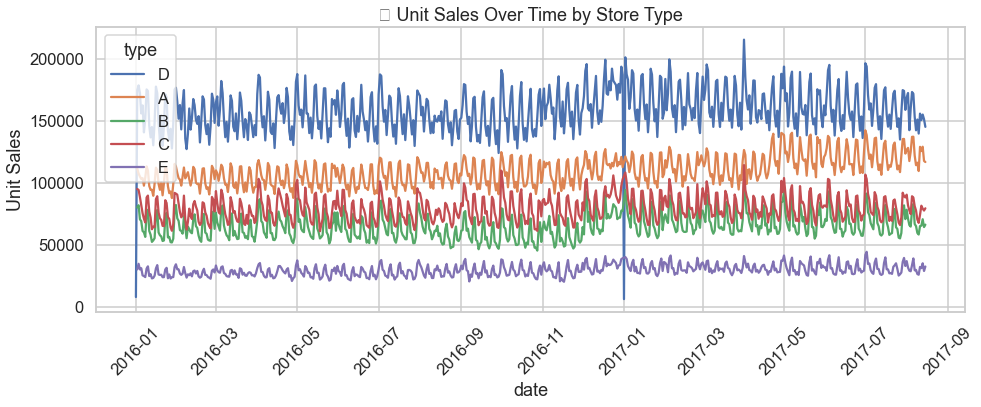

In [26]:
type_daily = df.groupby(['date', 'type'])['unit_sales'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(data=type_daily, x='date', y='unit_sales', hue='type')
plt.title('📅 Unit Sales Over Time by Store Type')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Store Type D Has Highest Sales: Store type D (blue line) consistently exhibits the highest daily unit sales throughout the observed period, significantly outperforming the other store types.
Store Type A Second Highest: Store type A (orange line) generally shows the second-highest daily unit sales.
Lower Sales for Types B and C: Store types B (green line) and C (red line) have considerably lower daily unit sales compared to A and D, with their lines often overlapping or staying within a similar range.
Store Type E Lowest Sales: Store type E (purple line) consistently displays the lowest daily unit sales among all the store types.
Seasonality Across All Types: All store types appear to exhibit a similar weekly seasonal pattern in their daily sales, with regular ups and downs throughout the year.
Outlier Impact: The dip and recovery around early 2017, seen in overall sales, is also visible across most store types, suggesting a widespread event affected sales across different store types.

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


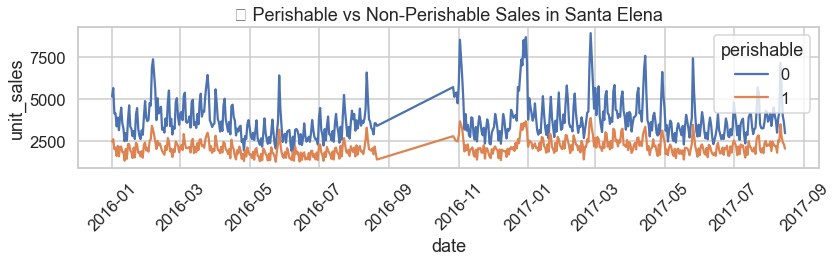

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


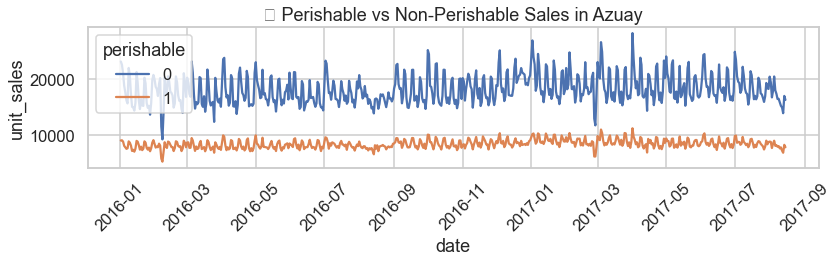

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


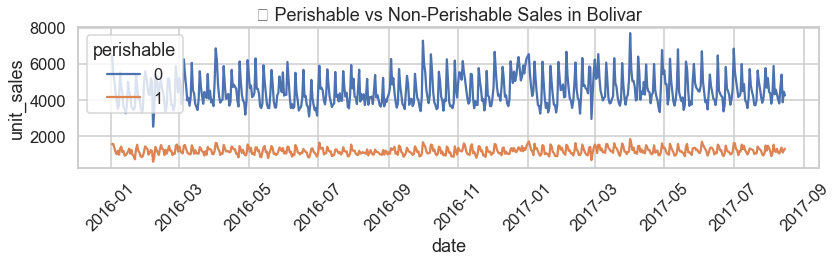

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


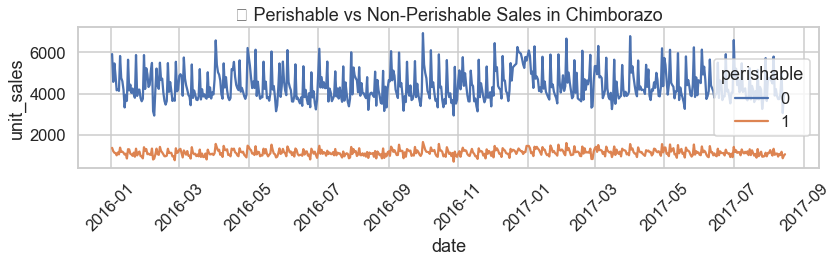

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


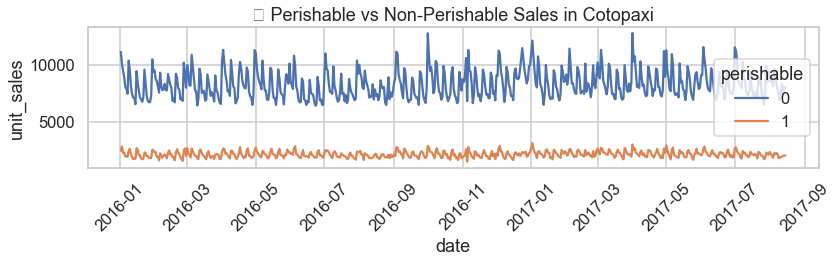

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


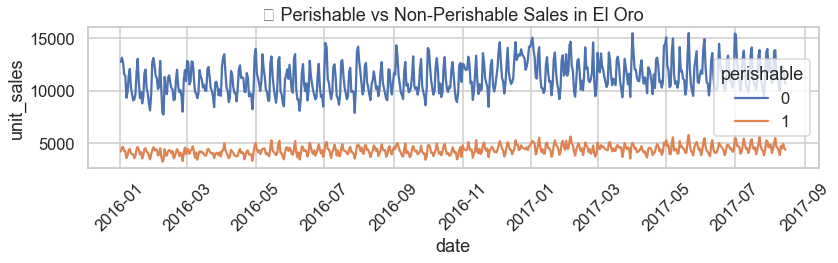

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


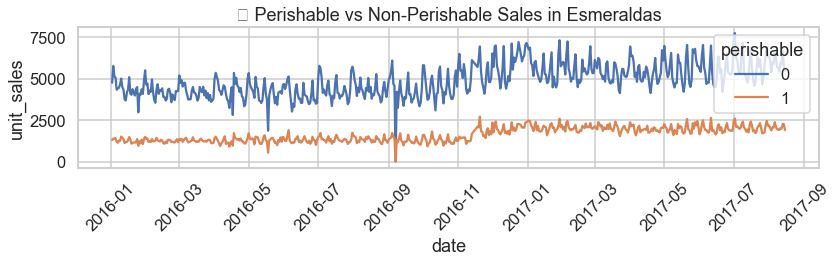

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


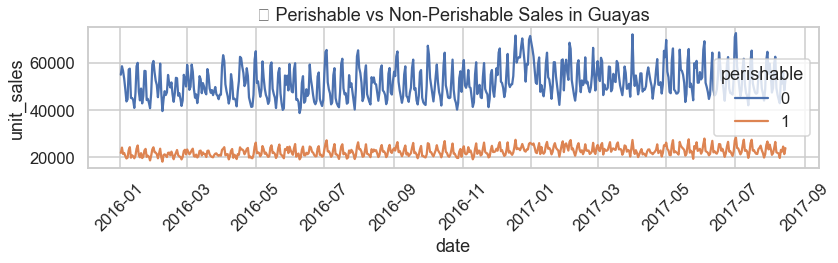

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


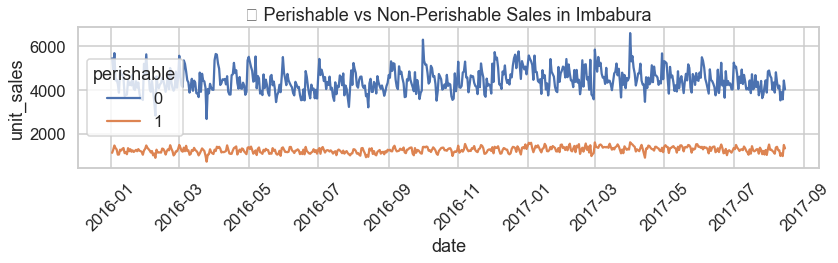

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


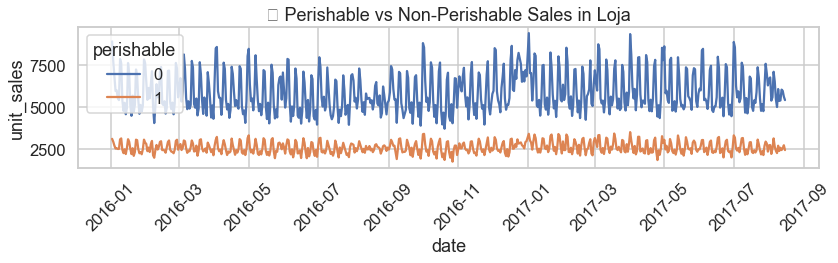

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


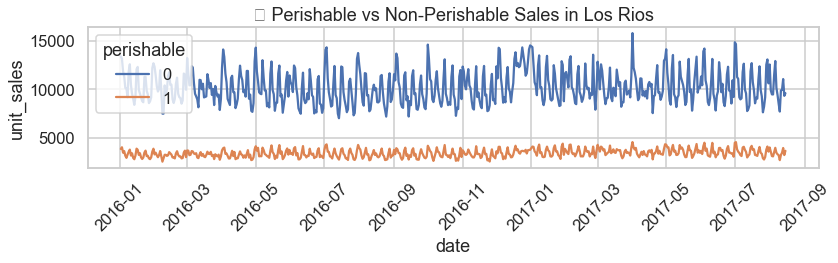

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


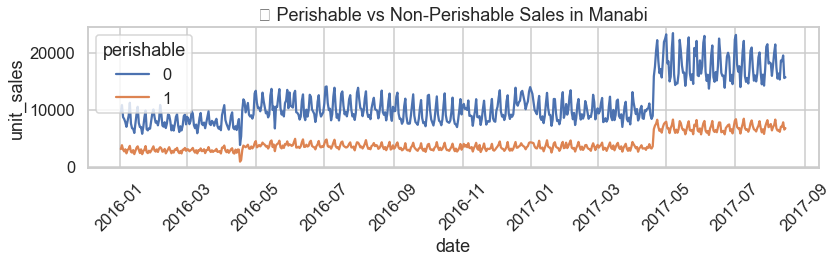

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


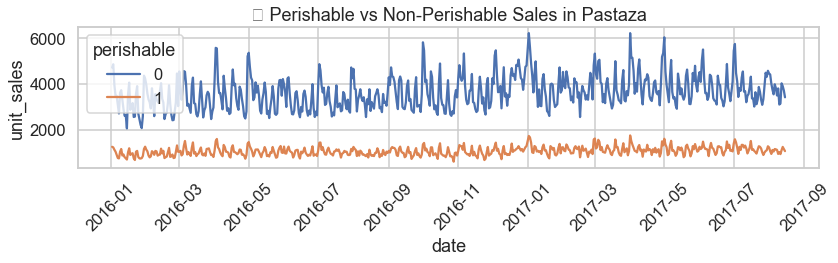

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


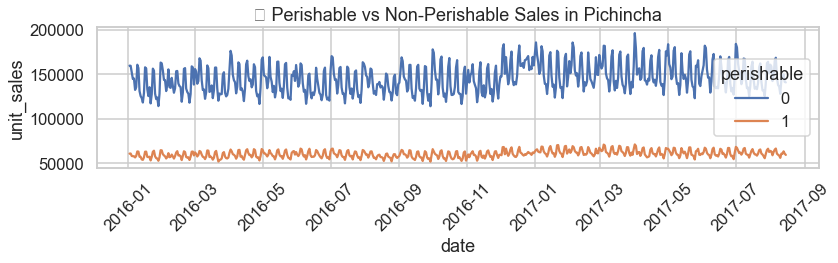

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


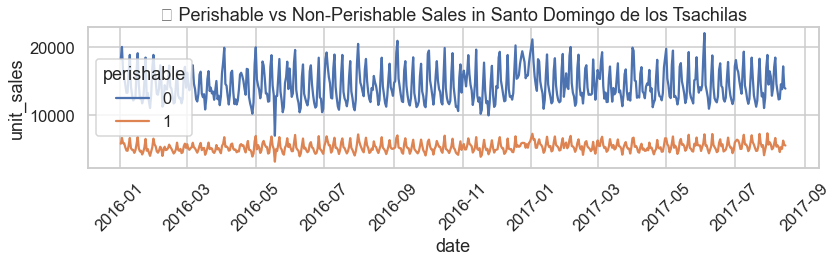

C:\Users\Dell\AppData\Local\Temp\ipykernel_12908\1779255483.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


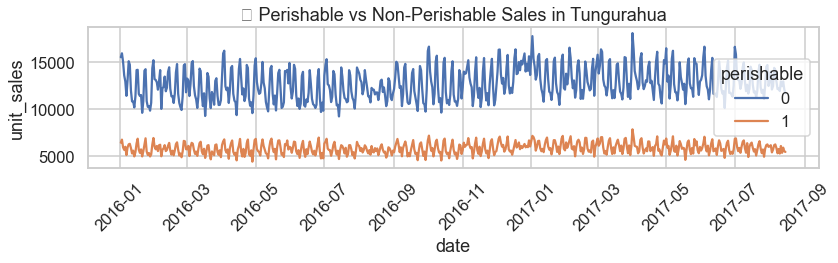

In [27]:
state_perish_daily = df.groupby(['date', 'state', 'perishable'])['unit_sales'].sum().reset_index()

# Pivot for stack plot or separate lines
for state in state_perish_daily['state'].unique():
    sub = state_perish_daily[state_perish_daily['state'] == state]
    plt.figure(figsize=(12,4))
    sns.lineplot(data=sub, x='date', y='unit_sales', hue='perishable')
    plt.title(f'📦 Perishable vs Non-Perishable Sales in {state}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54063292 entries, 0 to 54063291
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   date            datetime64[ns]
 2   unit_sales      float64       
 3   onpromotion     bool          
 4   city            object        
 5   state           object        
 6   type            object        
 7   cluster         int64         
 8   family          object        
 9   class           int64         
 10  perishable      int64         
 11  avg_unit_sales  float64       
 12  day_of_week     int64         
 13  month           int64         
 14  year            int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(7), object(4)
memory usage: 5.7+ GB


# Feature Engineering

In [29]:
df.head()

,id,date,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable,avg_unit_sales,day_of_week,month,year
0,66894873,2016-01-06,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,4.254618,2,1,2016
1,67077674,2016-01-08,4.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,4.254618,4,1,2016
2,67173081,2016-01-09,6.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,4.254618,5,1,2016
3,67549594,2016-01-13,1.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,4.254618,2,1,2016
4,67638605,2016-01-14,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,4.254618,3,1,2016


In [30]:
# Month start/end flags
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

# Weekly lag (most important, given EDA)
df['sales_lag_7'] = df.groupby(['city', 'family'])['unit_sales'].shift(7)

# Optional: Monthly lag (if monthly trends exist)
df['sales_lag_30'] = df.groupby(['city', 'family'])['unit_sales'].shift(30)

# # 7-day rolling mean (matches weekly seasonality)
# df['rolling_7d_mean'] = df.groupby(['city', 'family'])['unit_sales'].transform(
#     lambda x: x.rolling(7, min_periods=1).mean()
# )

# # 7-day rolling std (volatility)
# df['rolling_7d_std'] = df.groupby(['city', 'family'])['unit_sales'].transform(
#     lambda x: x.rolling(7, min_periods=1).std()
# )

# Weekly seasonality (from EDA)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Monthly trends (optional, if monthly patterns exist)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54063292 entries, 0 to 54063291
Data columns (total 23 columns):
 #   Column          Dtype         
---  ------          -----         
 0   id              int64         
 1   date            datetime64[ns]
 2   unit_sales      float64       
 3   onpromotion     bool          
 4   city            object        
 5   state           object        
 6   type            object        
 7   cluster         int64         
 8   family          object        
 9   class           int64         
 10  perishable      int64         
 11  avg_unit_sales  float64       
 12  day_of_week     int64         
 13  month           int64         
 14  year            int64         
 15  is_month_start  int32         
 16  is_month_end    int32         
 17  sales_lag_7     float64       
 18  sales_lag_30    float64       
 19  day_sin         float64       
 20  day_cos         float64       
 21  month_sin       float64       
 22  month_cos       

,id,date,unit_sales,onpromotion,city,state,type,cluster,family,class,...,month,year,is_month_start,is_month_end,sales_lag_7,sales_lag_30,day_sin,day_cos,month_sin,month_cos
0,66894873,2016-01-06,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,1,2016,0,0,NaN,NaN,0.974928,-0.222521,0.5,0.866025
1,67077674,2016-01-08,4.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,1,2016,0,0,NaN,NaN,-0.433884,-0.900969,0.5,0.866025
2,67173081,2016-01-09,6.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,1,2016,0,0,NaN,NaN,-0.974928,-0.222521,0.5,0.866025
3,67549594,2016-01-13,1.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,1,2016,0,0,NaN,NaN,0.974928,-0.222521,0.5,0.866025
4,67638605,2016-01-14,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,1,2016,0,0,NaN,NaN,0.433884,-0.900969,0.5,0.866025


In [31]:
# Log transform (use log1p to handle zeros)
df['log_unit_sales'] = np.log1p(df['unit_sales'])

# Inverse transform for predictions
def inverse_log1p(x):
    return np.expm1(x)

In [32]:
#  Promotion uplift ratio (per family)  
df['promo_uplift'] = df.groupby('family')['unit_sales'].transform(  
    lambda x: x[df['onpromotion']].mean() / x[~df['onpromotion']].mean()  
)  


In [33]:
#  Promotion-perishable interaction  
df['promo_x_perishable'] = df['onpromotion'] * df['perishable']  


In [ ]:
#  Ensure correct data types
df['onpromotion'] = df['onpromotion'].astype(bool)
df['city'] = df['city'].astype('category')  # Reduces memory usage

#  Calculate promotion strength using merge (no map)
promo_means = (
    df[df['onpromotion']]
    .groupby('city', observed=True)['unit_sales']
    .mean()
    .rename('promo_mean')
)

non_promo_means = (
    df[~df['onpromotion']]
    .groupby('city', observed=True)['unit_sales']
    .mean()
    .rename('non_promo_mean')
)

# Combine results safely
strength_df = (
    pd.concat([promo_means, non_promo_means], axis=1)
    .assign(
        promo_strength=lambda x: np.where(
            x['non_promo_mean'] == 0,  # Handle division by zero
            1,                         # Default to no uplift
            x['promo_mean'] / x['non_promo_mean']
        )
    )
    [['promo_strength']]  # Keep only the final metric
)

# Merge back to original dataframe
df = df.merge(
    strength_df,
    how='left',
    left_on='city',
    right_index=True
)

# Fill any remaining NaN values
df['promo_strength'] = df['promo_strength'].fillna(1)
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54063292 entries, 0 to 54063291
Data columns (total 27 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  int64         
 1   date                datetime64[ns]
 2   unit_sales          float64       
 3   onpromotion         bool          
 4   city                category      
 5   state               object        
 6   type                object        
 7   cluster             int64         
 8   family              object        
 9   class               int64         
 10  perishable          int64         
 11  avg_unit_sales      float64       
 12  day_of_week         int64         
 13  month               int64         
 14  year                int64         
 15  is_month_start      int32         
 16  is_month_end        int32         
 17  sales_lag_7         float64       
 18  sales_lag_30        float64       
 19  day_sin             float64       
 20  

,id,date,unit_sales,onpromotion,city,state,type,cluster,family,class,...,sales_lag_7,sales_lag_30,day_sin,day_cos,month_sin,month_cos,log_unit_sales,promo_uplift,promo_x_perishable,promo_strength
0,66894873,2016-01-06,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,0.974928,-0.222521,0.5,0.866025,1.098612,1.141981,0,1.420166
1,67077674,2016-01-08,4.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,-0.433884,-0.900969,0.5,0.866025,1.609438,1.141981,0,1.420166
2,67173081,2016-01-09,6.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,-0.974928,-0.222521,0.5,0.866025,1.945910,1.141981,0,1.420166
3,67549594,2016-01-13,1.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,0.974928,-0.222521,0.5,0.866025,0.693147,1.141981,0,1.420166
4,67638605,2016-01-14,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,0.433884,-0.900969,0.5,0.866025,1.098612,1.141981,0,1.420166


In [35]:
df.head()

,id,date,unit_sales,onpromotion,city,state,type,cluster,family,class,...,sales_lag_7,sales_lag_30,day_sin,day_cos,month_sin,month_cos,log_unit_sales,promo_uplift,promo_x_perishable,promo_strength
0,66894873,2016-01-06,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,0.974928,-0.222521,0.5,0.866025,1.098612,1.141981,0,1.420166
1,67077674,2016-01-08,4.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,-0.433884,-0.900969,0.5,0.866025,1.609438,1.141981,0,1.420166
2,67173081,2016-01-09,6.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,-0.974928,-0.222521,0.5,0.866025,1.945910,1.141981,0,1.420166
3,67549594,2016-01-13,1.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,0.974928,-0.222521,0.5,0.866025,0.693147,1.141981,0,1.420166
4,67638605,2016-01-14,2.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,...,NaN,NaN,0.433884,-0.900969,0.5,0.866025,1.098612,1.141981,0,1.420166


In [36]:
# Mean sales per city  
df['city_avg_sales'] = df.groupby('city')['unit_sales'].transform('mean')  

# Sales ratio vs. city average (normalize for scale)  
df['sales_ratio_vs_city'] = df['unit_sales'] / df['city_avg_sales']  

# Train Model

In [37]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [49]:
pip install --upgrade scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import math

In [39]:
df_sorted = df.sort_values('date').reset_index(drop=True)

In [ ]:
df_sorted.info()

In [ ]:
df_sorted.isna().sum()

In [40]:
# Drop rows where sales_lag_7 or sales_lag_30 is NaN
df_clean = df_sorted.dropna(subset=['sales_lag_7', 'sales_lag_30']).reset_index(drop=True)

In [41]:
# Prepare features and target
features = [
    'sales_lag_7', 'sales_lag_30', 'promo_strength', 'promo_x_perishable',
    'day_sin', 'day_cos', 'month_sin', 'month_cos', 
    'onpromotion', 'avg_unit_sales'
]
target = 'log_unit_sales'

X_clean = df_clean[features].copy()
X_clean['onpromotion'] = X_clean['onpromotion'].astype(int)
y_clean = df_clean[target].values

In [42]:
# Time-based split: 60% train, 20% test, 20% validation
n = len(df_clean)
train_end = int(0.6 * n)
test_end = int(0.8 * n)

X_train = X_clean.iloc[:train_end]
y_train = y_clean[:train_end]

X_test = X_clean.iloc[train_end:test_end]
y_test = y_clean[train_end:test_end]

X_val = X_clean.iloc[test_end:]
y_val = y_clean[test_end:]

In [58]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [50]:
model = Ridge(alpha=1.0, solver='lsqr')
model.fit(X_train, y_train)

Ridge(solver='lsqr')

In [51]:
#  Evaluate RMSE on test and validation sets
def rmse(true, pred):
    return math.sqrt(mean_squared_error(true, pred))

print(f"Test RMSE (log scale): {rmse(y_test, model.predict(X_test)):.4f}")
print(f"Validation RMSE (log scale): {rmse(y_val, model.predict(X_val)):.4f}")

Test RMSE (log scale): 0.5292
Validation RMSE (log scale): 0.5263


Validation RMSE (0.5263) is slightly lower than Test RMSE (0.5292).That suggests model generalized well: didn’t over‑fit to the training/validation data.The closeness of the two values implies stability: the model’s performance is consistent on unseen data.

In [ ]:
X.isna().sum()

sales_lag_7            4897
sales_lag_30          20910
promo_strength            0
promo_x_perishable        0
day_sin                   0
day_cos                   0
month_sin                 0
month_cos                 0
onpromotion               0
promo_strength            0
dtype: int64

In [ ]:
!pip install --upgrade lightgbm

In [46]:
import lightgbm as lgb

In [53]:
model = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [54]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
    categorical_feature=['onpromotion']
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.298984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 32425429, number of used features: 10
[LightGBM] [Info] Start training from score 1.538812
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's rmse: 0.518868	valid_0's l2: 0.269224


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              objective='regression', random_state=42, subsample=0.8)

In [55]:
# Evaluate
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.5189


In [56]:
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {val_rmse:.4f}")

Validation RMSE: 0.5165


In [59]:
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['rmse', 'mse', 'mae'],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
    categorical_feature=['onpromotion']  # or 'auto'
)

# Predict on test and validation sets
y_test_pred = model.predict(X_test)
y_val_pred  = model.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.240836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 32425429, number of used features: 10
[LightGBM] [Info] Start training from score 1.538812
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's rmse: 0.518868	valid_0's l2: 0.269224	valid_0's l1: 0.421808


In [60]:
def print_metrics(prefix, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{prefix} →  MSE: {mse:.4f},  RMSE: {rmse:.4f},  MAE: {mae:.4f},  R²: {r2:.4f}")

print_metrics("Test set",       y_test, y_test_pred)
print_metrics("Validation set", y_val,  y_val_pred)

Test set →  MSE: 0.2692,  RMSE: 0.5189,  MAE: 0.4218,  R²: 0.3873
Validation set →  MSE: 0.2668,  RMSE: 0.5165,  MAE: 0.4188,  R²: 0.3933


predictions miss the true value by about 0.52 units or 0.42 units